# 1. Exploratory Data Analysis

## 1.1 Detect and Handling Missing Values

In [555]:
import pandas as pd

df = pd.read_csv('american_bankruptcy_dataset.csv')
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 company_name    0
fyear           0
status_label    0
X1              0
X2              0
X3              0
X4              0
X5              0
X6              0
X7              0
X8              0
X9              0
X10             0
X11             0
X12             0
X13             0
X14             0
X15             0
X16             0
X17             0
X18             0
Division        0
MajorGroup      0
dtype: int64


## 1.2 Distinguish Attributes

| Column | Header                        | Description                                                  |
| ------ | ----------------------------- | ------------------------------------------------------------ |
| X1     | Current assets                | All the assets of a company that are expected to be sold or used as a result of standard business operations over the next year. |
| X2     | Cost of goods sold            | The total amount a company paid as a cost directly related to the sale of products. |
| X3     | Depreciation and amortization | Depreciation refers to the loss of value of a tangible fixed asset over time (such as property. machinery, buildings, and plant). Amortization refers to the loss of value of intangible assets over time. |
| X4     | EBITDA                        | Earnings before interest, taxes, depreciation and amortization: Measure of a company’s overall financial performance alternative to the net income. |
| X5     | Inventory                     | The accounting of items and raw materials that a company either uses in production or sells. |
| X6     | Net Income                    | The overall profitability of a company after all expenses and costs have been deducted from total revenue. |
| X7     | Total Receivables             | The balance of money due to a firm for goods or services delivered or used but not yet paid for by customers. |
| X8     | Market value                  | The price of an asset in a marketplace. In our dataset it refers to the market capitalization since companies are publicly traded in the stock market. |
| X9     | Net sales                     | The sum of a company’s gross sales minus its returns, allowances, and discounts. |
| X10    | Total assets                  | All the assets, or items of value, a business owns.          |
| X11    | Total Long term debt          | A company’s loans and other liabilities that will not become due within one year of the balance sheet date. |
| X12    | EBIT                          | Earnings before interest and taxes.                          |
| X13    | Gross Profit                  | The profit a business makes after subtracting all the costs that are related to manufacturing and selling its products or services. |
| X14    | Total Current Liabilities     | It is the sum of accounts payable, accrued liabilities and taxes such as Bonds payable at the end of the year, salaries and commissions remaining. |
| X15    | Retained Earnings             | The amount of profit a company has left over after paying all its direct costs, indirect costs, income taxes and its dividends to shareholders. |
| X16    | Total Revenue                 | The amount of income that a business has made from all sales before subtracting expenses. It may include interest and dividends from investments. |
| X17    | Total Liabilities             | The combined debts and obligations that the company owes to outside parties. |
| X18    | Total Operating Expenses      | The expense a business incurs through its normal business operations |


In [559]:
# Map alive to 0, failed to 1 in clolumn status_label

df['status_label'] = df['status_label'].map({'alive': 0, 'failed': 1})
print(df['status_label'])

0        0
1        0
2        0
3        0
4        0
        ..
78677    0
78678    0
78679    0
78680    0
78681    0
Name: status_label, Length: 78682, dtype: int64


## 1.3 Apply Benford's Law

In [524]:
def get_company_numeric_data(c_name):
    '''
    Get all numeric data of a selected company
    '''
    
    # Filter the data of the specified company based on company_name
    company_data = df[df['company_name'] == c_name]

    # Extract data from columns X1 to X18
    company_numeric_data = company_data.loc[:, 'X1':'X18'].values.flatten().tolist()

    return(company_numeric_data)

In [526]:
from collections import Counter

def frequency_of_first_digit(list):
    '''
    Calculate the frequency of the first digit
    '''
    # Get the first digit of the absolute value of all numbers
    first_digits = [int(str(abs(x))[0]) for x in list]

    # Count the number of occurrences of each first digit
    counter = Counter(first_digits)

    # Calculate the frequency of each number
    total_count = sum(counter.values())
    frequency = [counter.get(digit, 0) for digit in range(1, 10)]

    # print(frequency)

    return frequency

In [528]:
from scipy.stats import ks_2samp

def kolmogorov_smirnov_test(fre, theo_fre):
    '''
    Kolmogorov–Smirnov test
    '''
    statistic, p_value = ks_2samp(fre, theo_fre)

    return p_value

In [530]:
from scipy.stats import chisquare

def chi_square_test(observed, expected):
    # normalization
    observed = [x / sum(observed) for x in observed]
    
    chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")

    return p_value

In [532]:
import math

# calculate theoretical frequency

theoretical_frequency = [math.log10(1+1/digit) for digit in range(1, 10)]

print(theoretical_frequency)

[0.3010299956639812, 0.17609125905568124, 0.12493873660829993, 0.09691001300805642, 0.07918124604762482, 0.06694678963061322, 0.05799194697768673, 0.05115252244738129, 0.04575749056067514]


In [540]:
# count = 0
# for i in range(1, 8972):
#     c_name = 'C_'+str(i)
#     # print(c_name)
#     list = get_company_numeric_data(c_name)
#     fre = frequency_of_first_digit(list)
#     p_value = chi_square_test(fre, theoretical_frequency)
#     if p_value < 0.05:
#         count+=1
# print('Detected bankruptcy:', count)

We found that Benford's Law has no obvious effect on bankruptcy detection.

## 1.4 Univariate Analysis

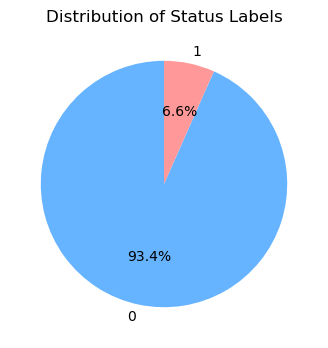

In [544]:
import matplotlib.pyplot as plt

# Count the occurrences of each unique value
status_counts = df['status_label'].value_counts()

# Create a pie chart to show the ratio of alive and failed
plt.figure(figsize=(4, 4))
plt.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',  # Display percentages
    startangle=90,      # Start pie chart at 90 degrees
    colors=['#66b3ff', '#ff9999']  # Custom colors
)

plt.title('Distribution of Status Labels')
plt.show()

According to pie chart, we can clearly find out this is an imbalance dataset. So we need to handle this problem with **sampling**. 

## 1.5 Multi-variate Analysis

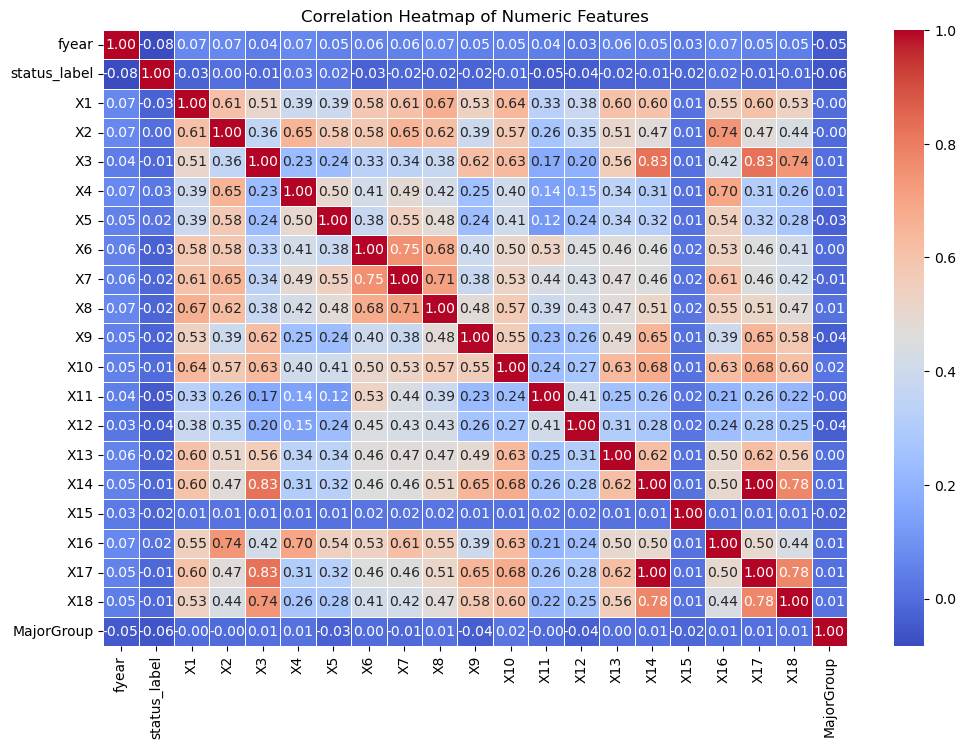

In [548]:
import seaborn as sns

# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

## 1.6 Feature Engineering

In [561]:
# Delete column company_name, fyear, MajorGroup
df = df.drop(columns=['company_name', 'fyear', 'MajorGroup'])

print(df.head())

   status_label        X1          X2        X3        X4        X5        X6  \
0             0  511267.0  740998.000  833107.0  180447.0  18373.00  70658.00   
1             0  485856.0     701.854  713811.0  179987.0  18577.00     45.79   
2             0  436656.0  710199.000  526477.0  217699.0  22496.00   4711.00   
3             0  396412.0     686.621  496747.0  164658.0  27172.00   3573.00   
4             0  432204.0     709.292  523302.0  248666.0     26.68  20811.00   

          X7         X8          X9       X10        X11         X12  \
0  89031.000  191226.00     336.018  163816.0     35.163  201026.000   
1  64367.000  160444.00     320.590  125392.0  18531.000  204065.000   
2  27207.000  112244.00  286588.000  150464.0    -58.939     139.603   
3  30745.000     109.59  259954.000  203575.0    -12.410  124106.000   
4     47.491  128656.00  247245.000  131261.0   3504.000  131884.000   

          X13          X14       X15       X16          X17       X18 Division  

In [595]:
from sklearn.preprocessing import LabelEncoder

# Convert the specified column(status_label, Division) to categorical encoding
label_encoders = {}
for col in ['status_label', 'Division']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoder for decoding

# Output the encoded data
print("\nEncoded data:")
print(df.tail())


Encoded data:
       status_label        X1          X2       X3          X4         X5  \
78677             0  233211.0  1099101.00  43338.0  184666.000  14094.000   
78678             0  105559.0  1865926.00  59184.0     770.103  42592.000   
78679             0   63971.0  1746235.00  69074.0  683985.000  65057.000   
78680             0  135207.0     1736.11  66527.0  694035.000     65.330   
78681             0   82589.0     1625.37  68817.0  632122.000     65.201   

               X6        X7        X8        X9        X10         X11  \
78677   31521.000   45615.0   60885.0     3.376  28197.000   25261.000   
78678  159541.000  202133.0  231969.0     2.288     88.128  129688.000   
78679      13.994   79051.0  100784.0     2.581  85765.000   -1442.000   
78680    3841.000   69171.0   95357.0  2013.000     82.010  -20401.000   
78681    2061.000   67262.0   91696.0  2112.000  79365.000     -50.946   

            X12      X13       X14          X15         X16       X17  \
7867

Based on the correlation between different columns in the heatmap and some bankruptcy financial knowledge, we created the following features. Next, we will add these features to the dataset and test whether they are helpful in improving the accuracy of the model.

1. **Financial leverage related**
   1. Total debt to total assets ratio (X17 / X10)
      - Measures the leverage level of the company, showing how much of its assets rely on debt financing. Excessive leverage may indicate an increased risk of bankruptcy.
   2. Current liabilities to total debt ratio (X14 / X17)
      - Measures the proportion of short-term debt in total debt. Higher short-term debt may reflect short-term debt repayment pressure.
2. **Profitability related**
   1. Net profit margin (X6 / X9)
      - Indicates the company's ability to obtain net income from sales. Low net profit margin may be a precursor to financial health problems.
   2. EBITDA profit margin (X4 / X9)
      - EBITDA reflects the core profitability of the company better than net profit. Analyze its relationship with bankruptcy.
   3. Gross profit margin (X13 / X9)
      - Reflects the basic profitability of the company's production and sales links. A decline in gross profit margin may indicate a weakening of competitiveness.
3. **Liquidity and turnover efficiency**
   1. Current ratio (X1 / X14)
      - Measures the company's short-term debt repayment ability. Too low may lead to liquidity crisis.
   2. Inventory turnover (X9 / X5)
      - Reflects the ability to convert inventory into cash. Inventory backlog may indicate capital turnover problems.
   3. Accounts receivable turnover (X9 / X7)
      - Measures the efficiency of the company's collection of sales revenue. Excessive accounts receivable may reflect customer payment problems.
4. **Market and value related**
   1. Market value to net assets ratio (X8 / X10)
      - A low market value relative to net assets ratio may reflect the market's lack of confidence in the company's profitability and prospects.
   2. Market value to revenue ratio (X8 / X16)
      - Measures the ratio of a company's market value to its revenue. Too low may indicate that the market underestimates the company's profit potential.
5. **Revenue and cost management**
   1. Revenue-cost difference (X16 - X2)
      - Directly reflects the surplus of revenue relative to cost. Excessive cost may erode profit margins.
   2. Operating expense ratio (X18 / X16)
      - Shows the proportion of operating expenses in revenue. Too high may be a signal of inefficiency.
6. **Return on investment and retained earnings**
   1. Return on assets (X6 / X10)
      - Measures the company's ability to use assets to generate net income. A low return on assets may be a sign of declining corporate efficiency.
   2. Retained earnings ratio (X15 / X6)
      - Reflects the proportion of net income reinvested in the business by the company. It may be an important signal of the company's strategic stability.

In [650]:
# Feature Engineering based on Feature Correlation and Financial Knowledge

# Add New Features with safeguards against division by zero or NaN
import numpy as np

# Leverage-related features
df['leverage_ratio'] = np.where(df['X10'] != 0, df['X17'] / df['X10'], 0)  # Total liabilities to total assets ratio
df['short_term_debt_ratio'] = np.where(df['X17'] != 0, df['X14'] / df['X17'], 0)  # Current liabilities to total liabilities ratio

# Profitability-related features
df['net_profit_margin'] = np.where(df['X9'] != 0, df['X6'] / df['X9'], 0)  # Net profit margin
df['ebitda_margin'] = np.where(df['X9'] != 0, df['X4'] / df['X9'], 0)  # EBITDA margin
df['gross_profit_margin'] = np.where(df['X9'] != 0, df['X13'] / df['X9'], 0)  # Gross profit margin

# Liquidity and turnover efficiency features
df['current_ratio'] = np.where(df['X14'] != 0, df['X1'] / df['X14'], 0)  # Current ratio
df['inventory_turnover'] = np.where(df['X5'] != 0, df['X9'] / df['X5'], 0)  # Inventory turnover ratio
df['receivables_turnover'] = np.where(df['X7'] != 0, df['X9'] / df['X7'], 0)  # Receivables turnover ratio

# Market and value-related features
df['market_to_book_ratio'] = np.where(df['X10'] != 0, df['X8'] / df['X10'], 0)  # Market value to book value ratio
df['market_to_revenue_ratio'] = np.where(df['X16'] != 0, df['X8'] / df['X16'], 0)  # Market value to revenue ratio

# Revenue and cost management features
df['revenue_cost_difference'] = df['X16'] - df['X2']  # Revenue minus cost of goods sold
df['opex_ratio'] = np.where(df['X16'] != 0, df['X18'] / df['X16'], 0)  # Operating expenses to total revenue ratio

# Investment return and retained earnings features
df['return_on_assets'] = np.where(df['X10'] != 0, df['X6'] / df['X10'], 0)  # Return on assets
df['retained_earnings_ratio'] = np.where(df['X6'] != 0, df['X15'] / df['X6'], 0)  # Retained earnings to net income ratio

# Replace any remaining NaN or infinity values with 0
df = df.replace([np.inf, -np.inf], 0).fillna(0)

# Display the first few rows of the dataframe to confirm new features are added
print(df.head())


   status_label        X1          X2        X3        X4        X5        X6  \
0             0  511267.0  740998.000  833107.0  180447.0  18373.00  70658.00   
1             0  485856.0     701.854  713811.0  179987.0  18577.00     45.79   
2             0  436656.0  710199.000  526477.0  217699.0  22496.00   4711.00   
3             0  396412.0     686.621  496747.0  164658.0  27172.00   3573.00   
4             0  432204.0     709.292  523302.0  248666.0     26.68  20811.00   

          X7         X8          X9  ...  gross_profit_margin  current_ratio  \
0  89031.000  191226.00     336.018  ...             0.381968       0.499122   
1  64367.000  160444.00     320.590  ...           359.296921       0.555737   
2  27207.000  112244.00  286588.000  ...             0.270521       0.683641   
3  30745.000     109.59  259954.000  ...             0.255130       0.653782   
4     47.491  128656.00  247245.000  ...             0.423309     662.932275   

   inventory_turnover  receivabl

In [654]:
# Check for any NaN or infinite values

print(df.isnull().sum())  # Verify no missing values
print(np.isinf(df).sum().sum())  # Verify no infinite values

status_label               0
X1                         0
X2                         0
X3                         0
X4                         0
X5                         0
X6                         0
X7                         0
X8                         0
X9                         0
X10                        0
X11                        0
X12                        0
X13                        0
X14                        0
X15                        0
X16                        0
X17                        0
X18                        0
Division                   0
leverage_ratio             0
short_term_debt_ratio      0
net_profit_margin          0
ebitda_margin              0
gross_profit_margin        0
current_ratio              0
inventory_turnover         0
receivables_turnover       0
market_to_book_ratio       0
market_to_revenue_ratio    0
revenue_cost_difference    0
opex_ratio                 0
return_on_assets           0
retained_earnings_ratio    0
dtype: int64
0

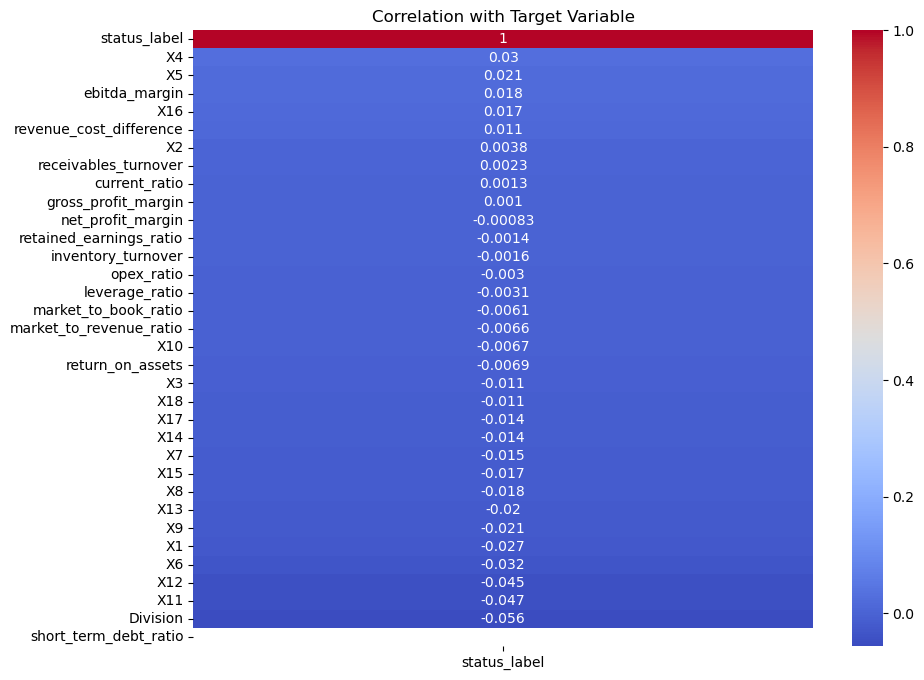

In [656]:
# Analyze Feature Correlations

# Compute the correlation matrix
correlation = df.corr()

# Plot a heatmap of correlations with the target variable 'status_label'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation[['status_label']].sort_values(by='status_label', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title("Correlation with Target Variable")
plt.show()

# 2. Prepare Datasets

## 2.1 Split Datasets by alive and failed ratio 

In [660]:
from sklearn.model_selection import train_test_split

# Split datasets based on the ratio of alive and failed
X = df.drop('status_label', axis=1)
y = df['status_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Size and ratio of training and testing datasets
print("Training set size:", X_train.shape)
print("\nTest set size:", X_test.shape)
print("\nTraining set:")
print(y_train.value_counts(normalize=True))
print("\nTesting set:")
print(y_test.value_counts(normalize=True))

Training set size: (62945, 33)

Test set size: (15737, 33)

Training set:
status_label
0    0.933656
1    0.066344
Name: proportion, dtype: float64

Testing set:
status_label
0    0.93366
1    0.06634
Name: proportion, dtype: float64


## 2.2 Handling Imbalance Datasets

Faced with imbalance datasets, we use SMOTE to oversampling. We will generate new minority class samples through interpolation.

In [664]:
from imblearn.over_sampling import SMOTE

# Oversampling by SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Training set size:", X_resampled.shape)
print("\nTesting set after oversampling:")
print(pd.Series(y_resampled).value_counts())

Training set size: (117538, 33)

Testing set after oversampling:
status_label
0    58769
1    58769
Name: count, dtype: int64


# 3. Train and Test Datasets 

In [714]:
from sklearn.model_selection import cross_val_score

# Model A: Use only the original features
X_o = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']]
y_o = df['status_label']
model_a = RandomForestClassifier(random_state=42)
auc_original = cross_val_score(model_a, X_o, y_o, cv=5, scoring='roc_auc').mean()

# Print AUC comparison
print(f"AUC with Original Features: {auc_original:.4f}")

AUC with Original Features: 0.6623


In [716]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

# Model B: Use preprocessed resampled dataset
X_only_resampled = X_resampled[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']]
clf_b = RandomForestClassifier(random_state=42)
clf_b.fit(X_only_resampled, y_resampled)

# Predict on testing set
y_pred = clf_b.predict(X_test[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']])

# Model evaluation
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate AUC on the test set
y_pred_proba = clf_b.predict_proba(X_test[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']])[:, 1]  # Probabilities for the positive class
auc_test = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC on Test Set: {auc_test:.4f}")


Classification report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     14693
           1       0.19      0.20      0.19      1044

    accuracy                           0.89     15737
   macro avg       0.56      0.57      0.57     15737
weighted avg       0.89      0.89      0.89     15737


Confusion matrix:
[[13769   924]
 [  833   211]]

AUC on Test Set: 0.7139


In [711]:
# Model C: Use preprocessed resampled dataset
clf_c = RandomForestClassifier(random_state=42)
clf_c.fit(X_resampled, y_resampled)

# Predict on testing set
y_pred = clf_c.predict(X_test)

# Model evaluation
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate AUC on the test set
y_pred_proba = clf_c.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
auc_test = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC on Test Set: {auc_test:.4f}")


Classification report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     14693
           1       0.31      0.16      0.21      1044

    accuracy                           0.92     15737
   macro avg       0.62      0.57      0.59     15737
weighted avg       0.90      0.92      0.91     15737


Confusion matrix:
[[14307   386]
 [  874   170]]

AUC on Test Set: 0.7563
